<a href="https://colab.research.google.com/github/jessica550/insta-engagement-prediction/blob/main/LINEAR_REGRESSION_INSTA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Visualização inicial dos dados carregados:
   rank channel_info  influence_score  posts followers avg_likes  \
0     1    cristiano               92   3.3k    475.8m      8.7m   
1     2  kyliejenner               91   6.9k    366.2m      8.3m   
2     3     leomessi               90  0.89k    357.3m      6.8m   
3     4  selenagomez               93   1.8k    342.7m      6.2m   
4     5      therock               91   6.8k    334.1m      1.9m   

  60_day_eng_rate new_post_avg_like total_likes        country  
0           1.39%              6.5m       29.0b          Spain  
1           1.62%              5.9m       57.4b  United States  
2           1.24%              4.4m        6.0b            NaN  
3           0.97%              3.3m       11.5b  United States  
4           0.20%            665.3k       12.5b  United States  
Removendo coluna irrelevante: channel_info
Removendo coluna irrelevante: country


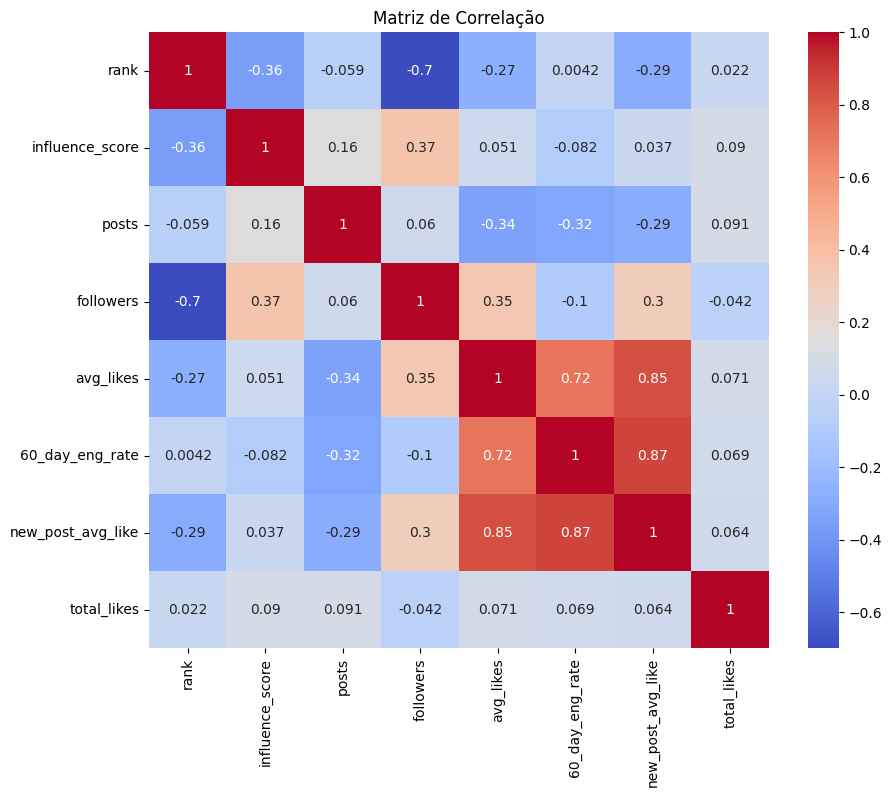

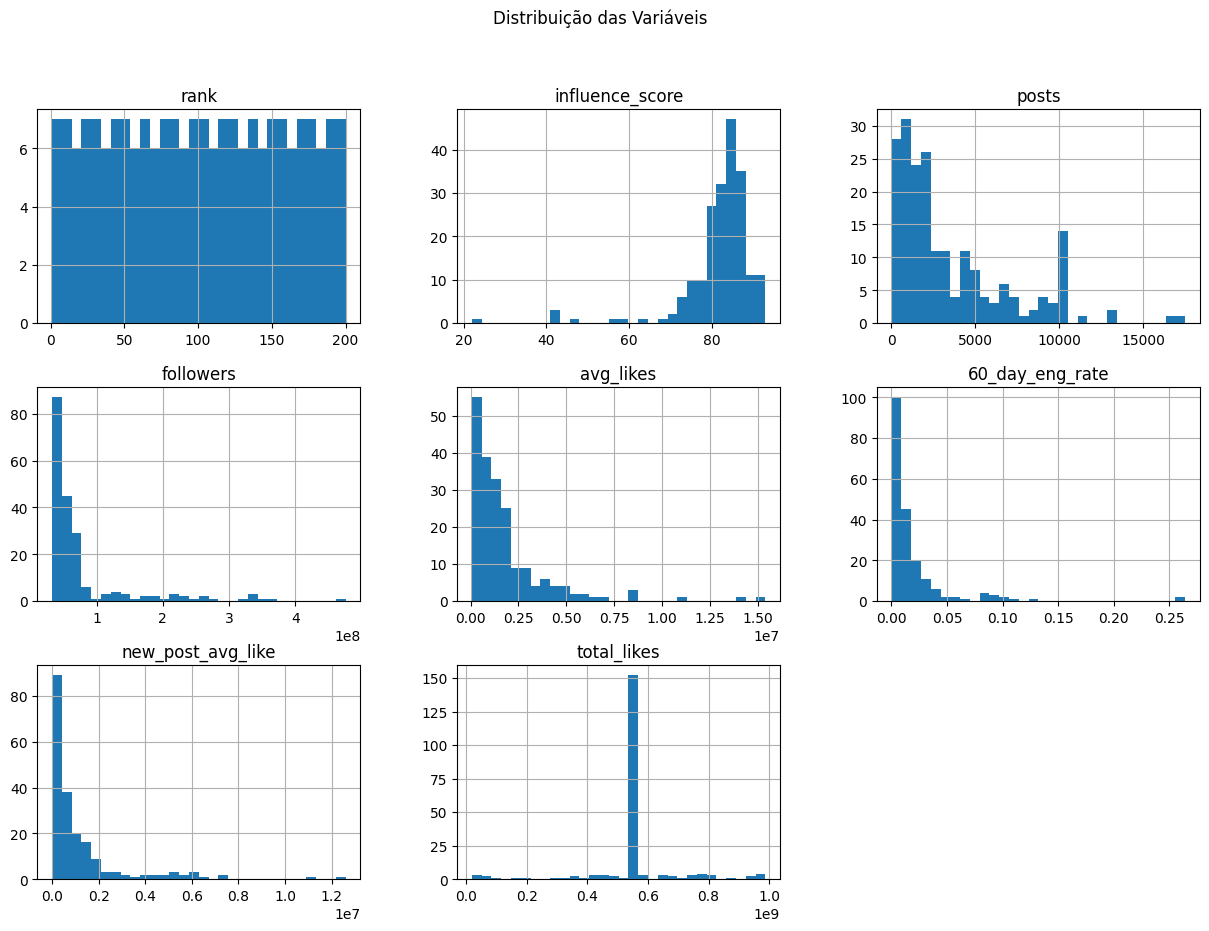

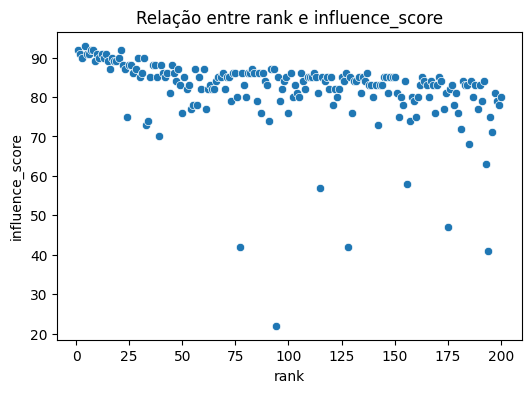

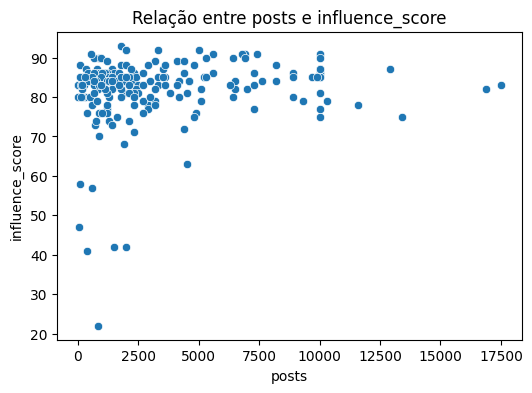

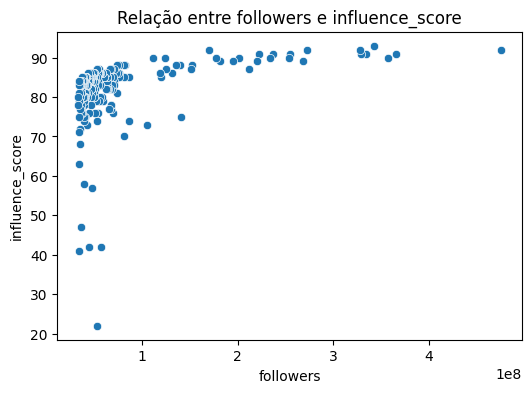

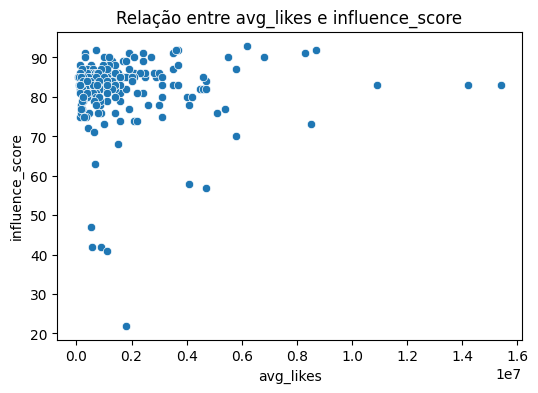

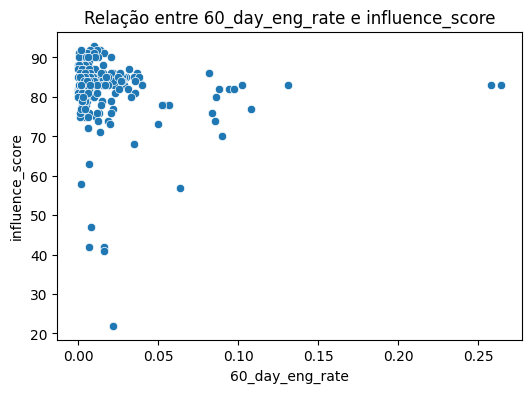

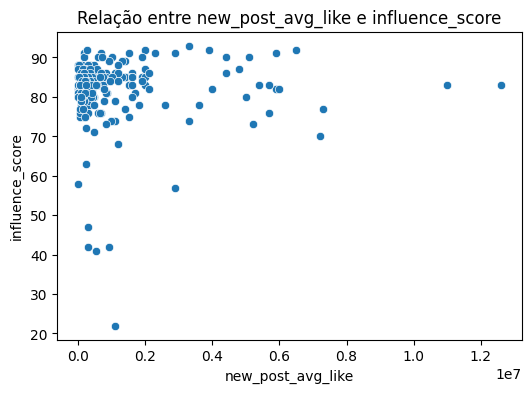

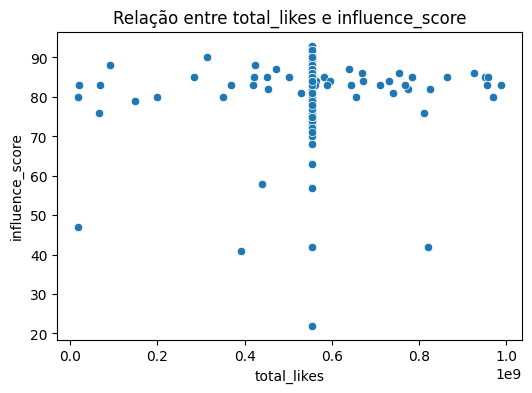

Variáveis com correlação relevante: ['rank', 'influence_score', 'posts', 'followers']
Variáveis selecionadas pelo SelectKBest: ['rank', 'posts', 'followers']

Desempenho da Regressão Linear:
MSE: 162.39217334421187
RMSE: 12.74331877276135
MAE: 5.7800978170372135

Ridge RMSE: 12.743322321265136
Lasso RMSE: 12.758634209451824

Melhores hiperparâmetros para Ridge: {'alpha': 10.0}
Melhores hiperparâmetros para Lasso: {'alpha': 0.01}


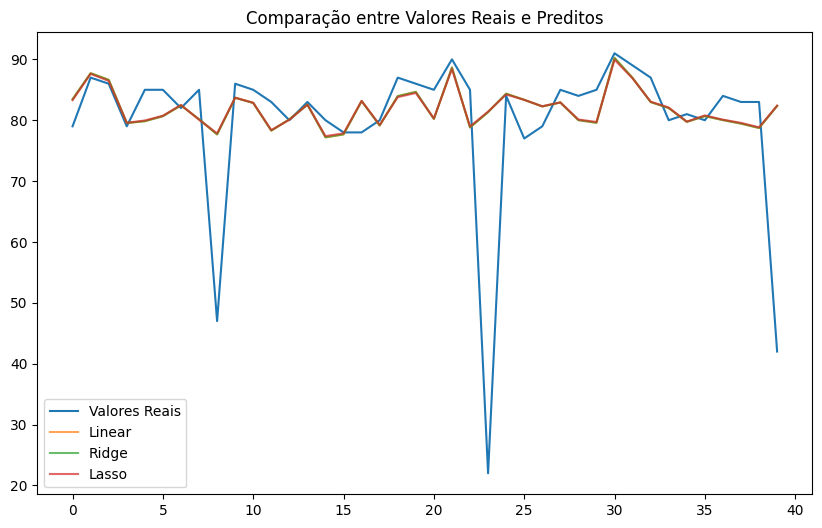

In [2]:
# Importação das bibliotecas
# Bibliotecas utilizadas para manipulação de dados, visualizações e construção de modelos
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Passo 1 - Carregar o Dataset
# Caminho ajustado para acessar o arquivo no diretório correto
dataset_path = "../data/top_insta_influencers_data.csv"
df = pd.read_csv(dataset_path)
print("Visualização inicial dos dados carregados:")
print(df.head())

# Remoção de colunas que não contribuem para o modelo preditivo
text_columns = ['channel_info', 'country']  # Colunas com informações textuais irrelevantes
for col in text_columns:
    if col in df.columns:
        print(f"Removendo coluna irrelevante: {col}")
        df = df.drop(columns=[col])

# Conversão de formatos textuais para valores numéricos
# Função para lidar com valores abreviados como 'k' para mil e 'm' para milhões
def convert_k_m_to_numeric(value):
    if isinstance(value, str):
        if 'k' in value:
            return float(value.replace('k', '')) * 1e3
        elif 'm' in value:
            return float(value.replace('m', '')) * 1e6
    return value

# Função para converter porcentagens para valores decimais
def convert_percentage_to_float(value):
    if isinstance(value, str) and '%' in value:
        return float(value.replace('%', '')) / 100
    return value

# Aplicação das funções de conversão nas colunas do dataset
for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = df[col].apply(convert_k_m_to_numeric)
        df[col] = df[col].apply(convert_percentage_to_float)

# Garantir que todas as colunas sejam numéricas e tratar valores ausentes
df = df.apply(pd.to_numeric, errors='coerce')
df = df.fillna(df.mean())  # Substituir valores ausentes pela média de cada coluna

# Passo 2 - Análise Exploratória dos Dados
# Gerar matriz de correlação para identificar relações entre as variáveis
plt.figure(figsize=(10, 8))
numeric_df = df.select_dtypes(include=np.number)
sns.heatmap(numeric_df.corr(), annot=True, cmap="coolwarm")
plt.title("Matriz de Correlação")
plt.show()

# Visualizar a distribuição das variáveis
df.hist(bins=30, figsize=(15, 10))
plt.suptitle("Distribuição das Variáveis")
plt.show()

# Relação entre as variáveis independentes e a variável alvo ('influence_score')
target_column = 'influence_score'
feature_columns = [col for col in df.columns if col != target_column]

for col in feature_columns:
    plt.figure(figsize=(6, 4))
    sns.scatterplot(x=df[col], y=df[target_column])
    plt.title(f"Relação entre {col} e {target_column}")
    plt.show()

# Passo 3 - Seleção de Recursos
# Utilizar correlação para identificar as variáveis mais relevantes
correlation_threshold = 0.1
corr_matrix = df.corr()
relevant_features_corr = corr_matrix[target_column][abs(corr_matrix[target_column]) > correlation_threshold].index
print(f"Variáveis com correlação relevante: {list(relevant_features_corr)}")

# Selecionar apenas variáveis relevantes
df = df[relevant_features_corr]

# Seleção automática com SelectKBest
X = df.drop(columns=[target_column])
y = df[target_column]

k = min(5, X.shape[1])  # Garantir seleção de no máximo 5 variáveis
selector = SelectKBest(score_func=f_regression, k=k)
X_selected = selector.fit_transform(X, y)

selected_features = X.columns[selector.get_support(indices=True)]
print(f"Variáveis selecionadas pelo SelectKBest: {list(selected_features)}")

# Atualizar conjunto de dados com variáveis selecionadas
X = X[selected_features]

# Passo 4 - Divisão e Normalização dos Dados
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Passo 5 - Construção e Avaliação do Modelo de Regressão Linear
linear_model = LinearRegression()
linear_model.fit(X_train_scaled, y_train)

y_pred = linear_model.predict(X_test_scaled)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)

print("\nDesempenho da Regressão Linear:")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")

# Regularização: Modelos Ridge e Lasso
ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X_train_scaled, y_train)
ridge_pred = ridge_model.predict(X_test_scaled)
ridge_rmse = np.sqrt(mean_squared_error(y_test, ridge_pred))
print(f"\nRidge RMSE: {ridge_rmse}")

lasso_model = Lasso(alpha=0.1)
lasso_model.fit(X_train_scaled, y_train)
lasso_pred = lasso_model.predict(X_test_scaled)
lasso_rmse = np.sqrt(mean_squared_error(y_test, lasso_pred))
print(f"Lasso RMSE: {lasso_rmse}")

# Otimização de Hiperparâmetros
ridge_params = {'alpha': [0.1, 1.0, 10.0]}
lasso_params = {'alpha': [0.01, 0.1, 1.0]}

ridge_grid = GridSearchCV(Ridge(), ridge_params, scoring='neg_mean_squared_error', cv=5)
lasso_grid = GridSearchCV(Lasso(), lasso_params, scoring='neg_mean_squared_error', cv=5)

ridge_grid.fit(X_train_scaled, y_train)
lasso_grid.fit(X_train_scaled, y_train)

print(f"\nMelhores hiperparâmetros para Ridge: {ridge_grid.best_params_}")
print(f"Melhores hiperparâmetros para Lasso: {lasso_grid.best_params_}")

# Passo 6 - Comparação de Resultados
plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Valores Reais')
plt.plot(y_pred, label='Linear', alpha=0.7)
plt.plot(ridge_pred, label='Ridge', alpha=0.7)
plt.plot(lasso_pred, label='Lasso', alpha=0.7)
plt.legend()
plt.title("Comparação entre Valores Reais e Preditos")
plt.show()